In [60]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [62]:
df=pd.read_csv('Cleaned_Superstore_Sales_Data.csv')
# The first five rows of data in a tabular format
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Order Year,Order Month
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960,2017,11
1,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2017,6
2,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2016,10
3,6,CA-2015-115812,2015-06-09,2015-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.860,2015,6
4,7,CA-2015-115812,2015-06-09,2015-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,2015,6


In [68]:
# Split dataset by order year

df_2015 = df[df['Order Year']==2015]
df_2016 = df[df['Order Year']==2016]
df_2017 = df[df['Order Year']==2017]
df_2018 = df[df['Order Year']==2018]

## Forecasting
a. Create a graphical display of sales by month, separated by each year.

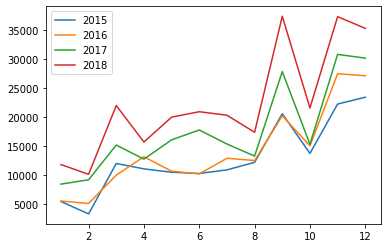

In [69]:
month_sales_2015 = pd.DataFrame(df_2015.groupby('Order Month')['Sales'].sum())
month_sales_2016 = pd.DataFrame(df_2016.groupby('Order Month')['Sales'].sum())
month_sales_2017 = pd.DataFrame(df_2017.groupby('Order Month')['Sales'].sum())
month_sales_2018 = pd.DataFrame(df_2018.groupby('Order Month')['Sales'].sum())

plt.plot(month_sales_2015['Sales'],label ='2015')
plt.plot(month_sales_2016['Sales'],label ='2016')
plt.plot(month_sales_2017['Sales'],label ='2017')
plt.plot(month_sales_2018['Sales'],label ='2018')
plt.legend()

The graph is shown above. It shows an increasing trend of sales within each year and an increasing trend in sales from 2015 to 2018.

## b1. Forecasting Method: ARIMA Model
ARIMA Model is a prediction model used for time series analysis and forecasting. It represents

Auto Regressive: lags of variables itself
Integrated: differencing steps required to make stationary
Moving Average: lags of previous information shocks
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

Pros:

Better understand the time-series patterns.
Its forecasts are usually more accurate and reliable.
Cons:

The data series used by ARIMA have to be stationary or be made stationary by differencing.
It only works on a single variable (a univariate model). Therefore it cannot exploit the leading indicators or explanatory variables.
It captures only linear relationships.
According to the graph above, our dataset could use the ARIMA model since it looks like there is a linear relationship between sales and years. However, we need to exclude the trend and seasonal effects to get a stationary dataset.

We could forecast the year for 2019 by each category or sub-category. Below, we take the furniture sales as an example.

#### Step1 : Stationarity
We will use the averages daily sales value to represent that month, and we are using the start of each month as the timestamp.

In [71]:
# Ensure 'Order Date' is in datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Set 'Order Date' as index
df.set_index('Order Date', inplace=True)

# Resample sales data by month and compute mean
y = df['Sales'].resample('MS').mean()

# Display data from 2018 onwards
pd.DataFrame(y['2018':])

,Sales
Order Date,
2018-01-01,95.778236
2018-02-01,107.343440
2018-03-01,102.595985
2018-04-01,84.189767
2018-05-01,92.371331
2018-06-01,100.437217
2018-07-01,101.430855
2018-08-01,95.281220
2018-09-01,90.451143


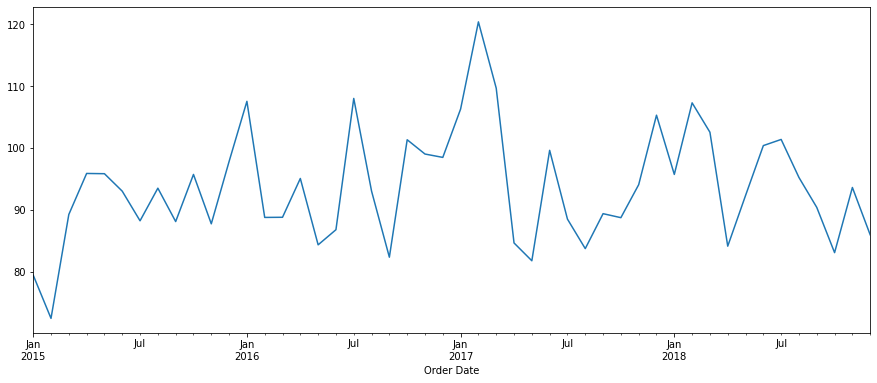

In [72]:
y.plot(figsize=(15, 6))
plt.show()

- The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
- Therefore, the dataset is unstationary.

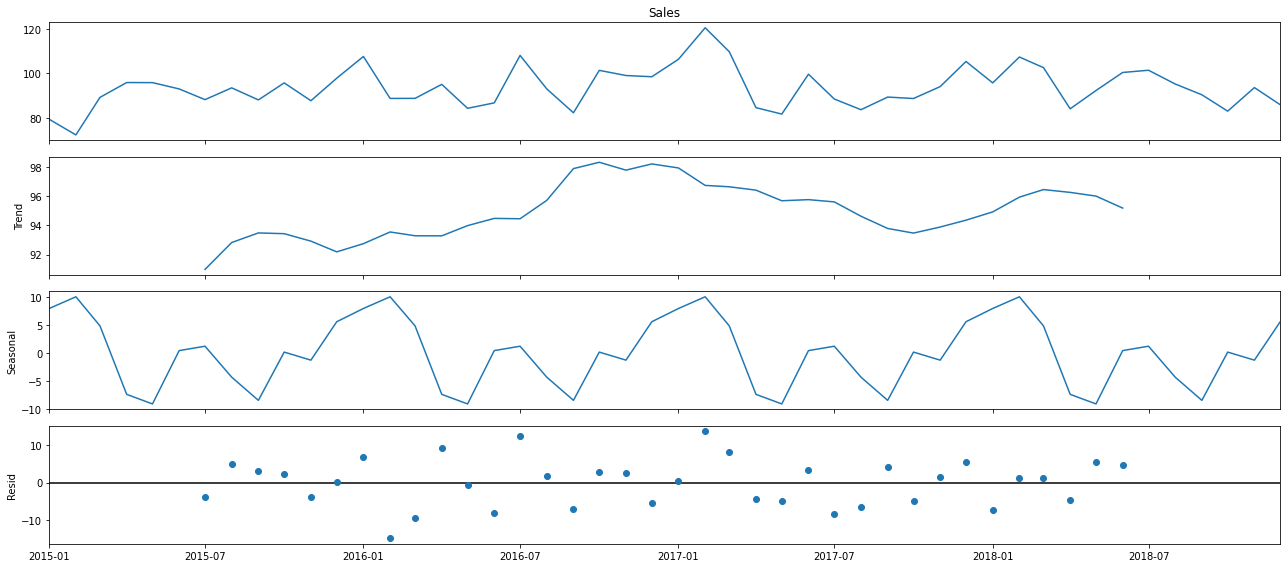

In [73]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

- The decomposition of the time series is shown above.

#### Step2 : Parameter Selection

In [75]:
# Parameter Selection 
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x 
                in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:562.8696534339073
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1115.2950332007383
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:272.2917575687596


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:183.0942833429998
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:286.5420014316649
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1473.8403800306348
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:190.51699981138748
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:183.67464563107202


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:495.6764705667674


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2503.033464222611
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:262.74630110701486
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:164.9041376420713
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:283.10693175859785


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2253.2879549253225
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:189.03796299964318
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:165.80695692239436
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:348.74384028525685


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:996.6233715112154
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:282.28096183804337
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:180.044480553571
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:271.673776576571


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1022.476676860655
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:191.4588130443966
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:180.27960643315
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:332.1818720667026


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1373.4915997139576
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:264.78318686962973
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:163.867299296904
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:264.86175938711847


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1349.9884983565585
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:187.51573533856396
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:165.8649336457609
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:357.6331131112623
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1393.0474279947148
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:272.8162777590371


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:183.61768860059232
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:274.7453803788387


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1242.1694640589524
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:183.7866955024902
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:185.4772244558447
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:342.3632639868733
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1421.0949352681696


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:260.9507415602375
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:165.28989097411272
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:276.4990968624565


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1286.0107377018949
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:182.20035478892976
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:165.38934080524598
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:348.9279592594184
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1416.6289204205082
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:282.318596357031


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:179.51145927086174
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:263.2128672205053
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1389.5582517263301
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:179.77857759121665


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:180.95908557685487
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:328.0975401245404
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1644.488129631423
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:265.5900809535081


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:165.2622284131075
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:255.0861800725024


c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nmber One\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1619.3739992322128
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:177.25212276424568
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:171.39072741553963


- The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.

#### Step3 : Fitting the ARIMA model

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3042      0.242      1.257      0.209      -0.170       0.778
ma.L1         -1.0000   2872.002     -0.000      1.000   -5630.020    5628.020
ar.S.L12       0.0185      0.097      0.192      0.848      -0.171       0.208
sigma2        76.9984   2.21e+05      0.000      1.000   -4.33e+05    4.34e+05


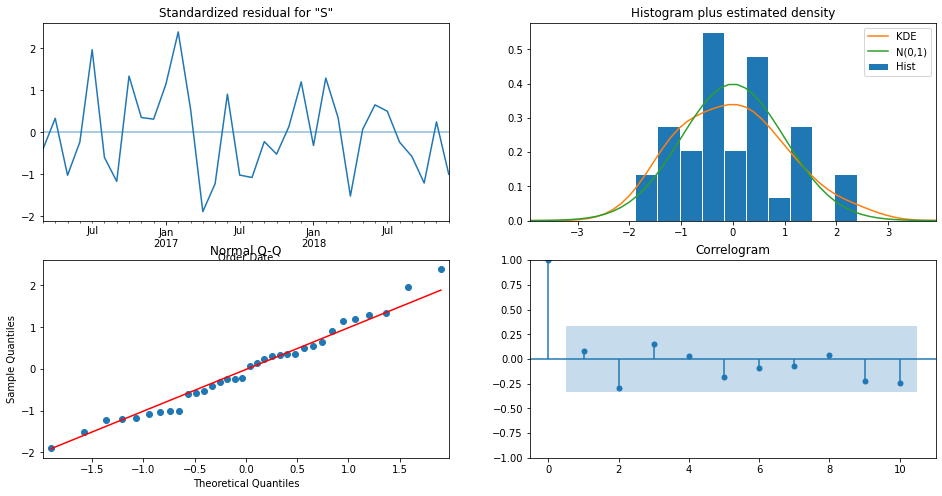

In [94]:
### Fitting the ARIMA model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(16, 8))
plt.show()

- Our model diagnostics suggests that the model residuals are near normally distributed.

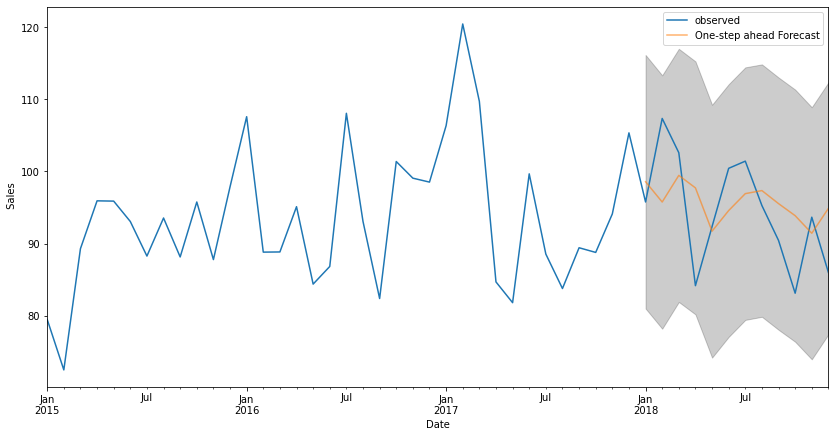

In [95]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.6, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel(' Sales')
plt.legend()
plt.show()

The plot shows the actual values compared to the forecasts. The predictions align well with the true data, capturing the upward trend at the start of the year and the seasonal patterns at the end.